In [1]:
pip install scikit-image


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob 
from pathlib import Path
from skimage.io import imread
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, GlobalMaxPool2D, MaxPooling2D, Dropout, BatchNormalization, Activation 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


In [3]:
train_data = '/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/train'
test_data = '/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/test'
val_data = '/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/val'

In [4]:
normal = Path(train_data + '/NORMAL')
pneumonia = Path(train_data + '/PNEUMONIA')
images_normal = normal.glob('*.jpeg')
images_pneumonia = pneumonia.glob('*.jpeg')

In [5]:
import pandas as pd

In [6]:
data_dir = Path('/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/chest_xray/train')  # Replace with the actual path to your data directory

train_data = []

normal = data_dir / 'NORMAL'
for img in normal.iterdir():
    train_data.append((img, 0))

pneumonia = data_dir / 'PNEUMONIA'
for img in pneumonia.iterdir():
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['Image', 'Class'])

In [7]:
train_data = train_data.sample(frac = 1).reset_index(drop = True)
train_data.head()

,Image,Class
0,/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/c...,1
1,/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/c...,0
2,/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/c...,1
3,/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/c...,1
4,/Users/deva/Desktop/DEVA/CSUN/Sem_3/Research/c...,1


# Pre-processing

In [8]:
image_size = (224, 224)
batch_size = 32

train_data['Image'] = train_data['Image'].astype(str)
train_data['Class'] = train_data['Class'].astype(str)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: tf.image.resize(x, image_size)
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='Image',
    y_col='Class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 5216 validated image filenames belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data,             
    target_size=image_size,    
    batch_size=batch_size,    
    class_mode='binary',       
    shuffle=False              
)

Found 624 images belonging to 2 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


# Model Building

In [11]:
inputs = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(inputs)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

In [12]:
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/10
163/163 [==============================] - 114s 695ms/step - loss: 2.4672 - accuracy: 0.7362 - val_loss: 0.6808 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 111s 681ms/step - loss: 0.5725 - accuracy: 0.7429 - val_loss: 0.6750 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 128s 785ms/step - loss: 0.5717 - accuracy: 0.7429 - val_loss: 0.7062 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 142s 868ms/step - loss: 0.5718 - accuracy: 0.7429 - val_loss: 0.6868 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 117s 718ms/step - loss: 0.5707 - accuracy: 0.7429 - val_loss: 0.6870 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 114s 697ms/step - loss: 0.5710 - accuracy: 0.7429 - val_loss: 0.7002 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 126s 771ms/step - loss: 0.5710 - accuracy: 0.7429 - val_loss: 0.6897 -

# Plotting loss and error

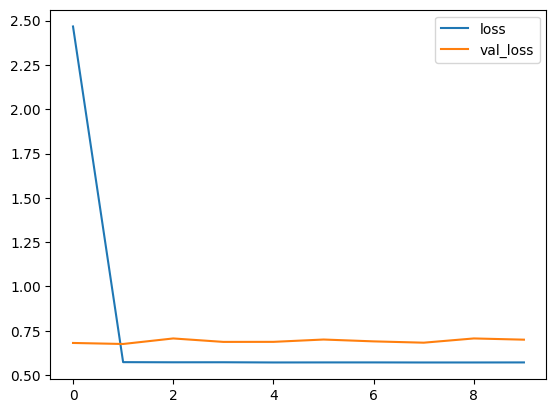

In [14]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

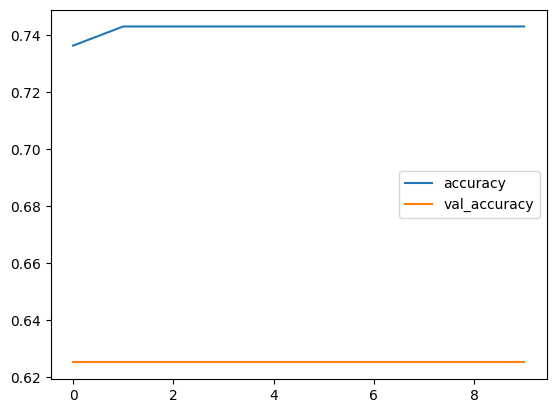

In [15]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

# Evaluating on test data

In [16]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    verbose=1
)

print("Test accuracy:", test_accuracy)

20/20 [==============================] - 4s 203ms/step - loss: 0.6994 - accuracy: 0.6250
Test accuracy: 0.625
